In [57]:
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pprint as pp #prints 3D list pretty
from scipy.integrate import trapz, cumtrapz
from numpy import pi, sqrt, cos, sin, arctan2, linspace, log, exp, sinh, arcsinh
import sys

## import ut scripts
import covert_xyz2lbr as ut
#import stellar_density_profiles as DenPro


from scipy.interpolate import griddata, NearestNDInterpolator, LinearNDInterpolator


from astropy.io import fits
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii
from astropy.wcs import WCS


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes


In [5]:
#From Mattia Sormani#

#############################
# Simple sampling function
#############################

def sinh_sampling(xmin,xmax,xcut,N):
    ymin, ymax = arcsinh(xmin/xcut), arcsinh(xmax/xcut)
    y          = np.linspace(ymin,ymax,N)
    x_sampling = xcut*sinh(y)
    return x_sampling

def sinh_double_sampling(xmax,xcut,Nx):
    # Nx must be odd
    x = sinh_sampling(0.0,xmax,xcut,int(Nx/2)+1)
    return np.hstack((-x[::-1][:-1],x))

In [6]:
##########################
# define bar density
##########################

# Sormani et al. 2020 model 3D NSD density
#def Calc_S20_NSD_rho(x,y,z):
def Calc_S20_NSD_rho(l,b,r):
    alpha   = 0.9
    rho1    = 222.885   # 1e10Msun/kpc^3
    R1      = 0.0050617 # kpc
    n1      = 0.7194    # dimensionless
    rho2    = 169.975   # 1e10Msun/kpc^3
    R2      = 0.0246    # kpc
    n2      = 0.7933    # dimensionless
    q       = 0.37      # dimensionless
    x,y,z,vx,vy,vz = ut.lbr2xyz(l,b,r,0,0,0)
    a       = sqrt(x**2+y**2+(z/q)**2)
    rho     = alpha*rho1*exp(-(a/R1)**n1) + alpha*rho2*exp(-(a/R2)**n2)
    return rho

# Launhardt et al. 2002 NSD density
#def Calc_L02_NSD_rho(x,y,z):
def Calc_L02_NSD_rho(l,b,r):
        nR1     = 5.0     # dimensionless
        nz1     = 1.4     # dimensionless
        rho1    = 15.228  # 10^10Msun/kpc^3
        R1      = 0.12    # kpc
        z1      = 0.045   # kpc
        nR2     = 5.0     # dimensionless
        nz2     = 1.4     # dimensionless
        rho2    = 3.888   # 10^10Msun/kpc^3
        R2      = 0.22    # kpc
        z2      = 0.045   # kpc
        log2    = log(2)
        x,y,z,vx,vy,vz = ut.lbr2xyz(l,b,r,0,0,0)
        R       = sqrt(x**2+y**2)
        A1      = rho1*exp(-log2*(  (R/R1)**nR1 + (np.abs(z)/z1)**nz1) )
        A2      = rho2*exp(-log2*(  (R/R2)**nR2 + (np.abs(z)/z2)**nz2) )
        rho     = A1 + A2
        return rho
    
# Chatzopoulos et al. 2015 NSC density; only important for central 10pc
def Calc_C15_NSC_rho(l,b,r):
    gamma = 0.71    # dimensionless
    q     = 0.73    # dimensionless
    a0    = 0.0059  # kpc
    M     = 0.0061  # 10^10Msun
    x,y,z,vx,vy,vz = ut.lbr2xyz(l,b,r,0,0,0)
    a     = sqrt(x**2+y**2+(z/q)**2)
    r_mask = (a<0.01) & (a !=  0)
    rho = np.zeros_like(a) ## this gives you an array of zeros shaped like a
    rho[r_mask] = (3.0-gamma)*M/(4*pi*q)*a0/((a[r_mask]**gamma)*((a[r_mask]+a0)**(4.0-gamma)))
    return rho
    
# Launhardt et al. 2002 Bar density
def Calc_L02_Bar_rho(x,y,z):
    rho0  = 0.8
    ax    = 1.1
    ay    = 0.36
    az    = 0.22
    Cperp = 1.6
    Cpar  = 3.2
    Rperp = ((np.abs(x)/ax)**Cperp + (np.abs(y)/ay)**Cperp)**(1.0/Cperp)
    Rs    = (Rperp**Cpar + (np.abs(z)/az)**Cpar)**(1.0/Cpar)
    rho   = rho0*exp(-Rs)
    return rho

# Exponential Disk Density Model
def Calc_n(l,b,r):
    n_0=2.1e-9 #kpc^-3 #2.097732758293176 pc^3
    h_thin = .350 #kpc
    h_r = 3.500 #kpc
    h_thick=1.500 #kpc
    x,y,z,vx,vy,vz = ut.lbr2xyz(l,b,r,0,0,0)
    R, theta, z = cart2pol(x, y, z)
    n_kpc = n_0*(np.exp(-z/h_thin) + 0.02*np.exp(-z/h_thick))*np.exp(-R/h_r)  #in kpc^-3
    return n_kpc

In [7]:
#Convert from polar to cartesian
def pol2cart(R, phi,z):
    x = R * np.cos(phi)
    y = R * np.sin(phi)
    return(x, y, z)

#Convert from cartesian to polar
def cart2pol(x, y, z):
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(R, phi, z)

def generate_polar_grid(NumPart):
    r = np.random.uniform(low=0., high=8., size=NumPart)
    phi = np.random.uniform(low=0., high=2.*np.pi, size=NumPart)
    z = np.random.uniform(low=-0.5, high=0.5, size=NumPart)
    
    pos = np.dstack((r,phi,z))[0]
    
    return pos

def generate_lbr_grid(NumPart):
    l = np.random.uniform(low=-2., high=2., size=NumPart)
    b = np.random.uniform(low=-0.35, high=0.35, size=NumPart)
    r = np.random.uniform(low=0., high=16.1, size=NumPart)
    
    pos = np.dstack((l,b,r))[0]
    
    return pos

In [60]:
### Cylinder of points in polar coordinates
pol_pos = generate_polar_grid(100000)
r, phi, z = pol_pos.T

### Convert to XYZ
X,Y,Z = pol2cart(r, phi,z)

### Convert to LBR and stack the point
L,B,R,_,_,_ = ut.xyz2lbr(X,Y,Z,0,0,0) #xyz2lbr correctly converts to degrees?
#L,B,R = np.rad2deg(L),np.rad2deg(B),np.rad2deg(R)
points_lbr = np.vstack((L,B,R)).T

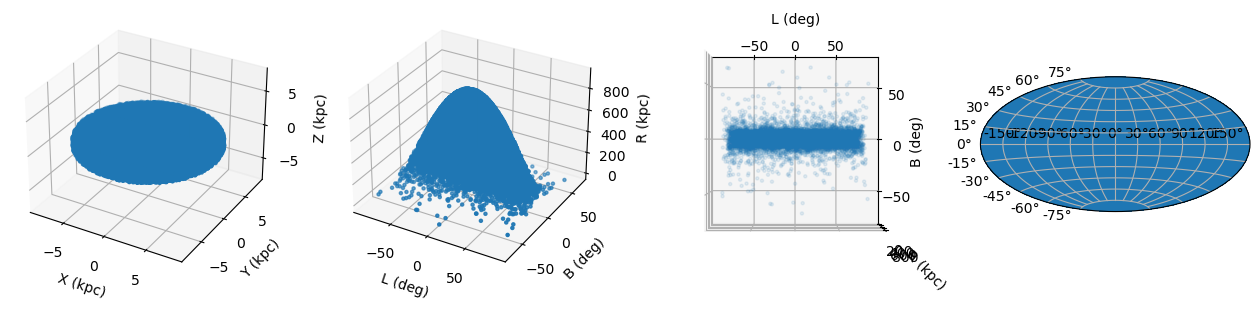

In [61]:
fig = plt.figure(figsize=(16,10))

ax0 = fig.add_subplot(1,4,1,projection='3d')
ax0.scatter(X, Y, Z, marker='.')
ax0.set_xlabel('X (kpc)')
ax0.set_ylabel('Y (kpc)')
ax0.set_zlabel('Z (kpc)')
ax0.set_zlim(-8,8)

ax1 = fig.add_subplot(1,4,2,projection='3d')
ax1.scatter(L, B, R, marker='.')
ax1.set_xlabel('L (deg)')
ax1.set_ylabel('B (deg)')
ax1.set_zlabel('R (kpc)')


ax2 = fig.add_subplot(1,4,3,projection='3d')
ax2.scatter(L, B, R, marker='.', alpha =0.1)
ax2.set_xlabel('L (deg)')
ax2.set_ylabel('B (deg)')
ax2.set_zlabel('R (kpc)')
ax2.view_init(90, -90)


eq = SkyCoord(L[:], B[:], unit=u.deg)
gal = eq.galactic
gal = SkyCoord(L[:], B[:], frame='galactic', unit=u.deg)

ax3 = fig.add_subplot(1,4,4,projection='aitoff')
ax3.grid(True)
ax3.scatter(gal.l.wrap_at('180d').deg, gal.b.deg)



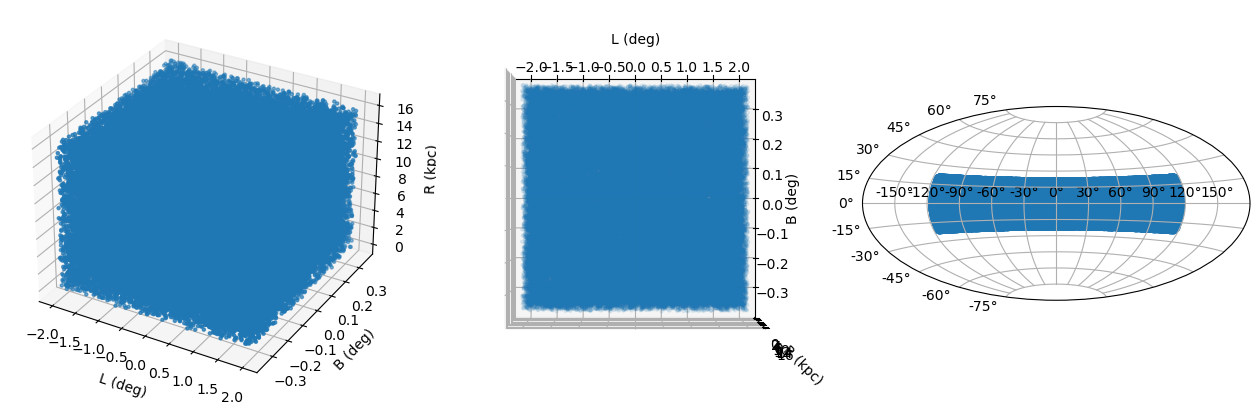

In [62]:
### Make cube in L,B,R? Better interpolation?
lbr_pos = generate_lbr_grid(100000)
L,B,R = lbr_pos.T

fig = plt.figure(figsize=(16,10))

ax0 = fig.add_subplot(1,3,1,projection='3d')
ax0.scatter(L,B,R, marker='.')
ax0.set_xlabel('L (deg)')
ax0.set_ylabel('B (deg)')
ax0.set_zlabel('R (kpc)')


ax1 = fig.add_subplot(1,3,2,projection='3d')
ax1.scatter(L,B,R, marker='.', alpha =0.1)
ax1.set_xlabel('L (deg)')
ax1.set_ylabel('B (deg)')
ax1.set_zlabel('R (kpc)')
ax1.view_init(90, -90)


eq = SkyCoord(L[:], B[:], unit=u.deg)
gal = eq.galactic
gal = SkyCoord(L[:], B[:], frame='galactic', unit=u.deg)

ax2 = fig.add_subplot(1,3,3,projection='aitoff')
ax2.grid(True)
ax2.scatter(gal.l.wrap_at('180d').deg, gal.b.deg)

plt.subplots_adjust(wspace=0.1)



In [75]:
### Define an evenly spaced grid in LBR 
### Herschel 70um image CRDELT=8.89E-04 deg
### step through r every parsec
stepl, stepb, stepr = 8.89E-04, 8.89E-04, 0.1

### define the extent of the plot
lmax, lmin = 2, -2
bmax, bmin = 0.35, -0.35
rmax, rmin = 9.1, 7
lgrid, bgrid, rgrid=np.arange(lmin,lmax,stepl),np.arange(bmin,bmax,stepb),np.arange(rmin,rmax,stepr)
LGRID,BGRID,RGRID = np.meshgrid(lgrid,bgrid,rgrid) #deg, deg, kpc

### need to convert to radians for the lbr2xyz calc?
lgrid_rad,bgrid_rad = np.deg2rad(lgrid), np.deg2rad(bgrid) 

In [76]:
L_rad,B_rad,R_kpc = np.meshgrid(lgrid_rad,bgrid_rad,rgrid) #rad, rad, kpc


In [77]:
### Calculate the RHOs for the NSD distribution + disk distribution
RHO_S20   = Calc_S20_NSD_rho(L_rad,B_rad,R_kpc)
RHO_C15   = Calc_C15_NSC_rho(L_rad,B_rad,R_kpc)
#RHO_n     = Calc_n(LGRID,BGRID,RGRID)

RHO_SUM = RHO_S20 + RHO_C15 

In [105]:
### Bin via a histogram to evalute the 2D distribution 


#mask for extents you want to make the histogram for
cond = (LGRID<lmax) & (LGRID>lmin) & (BGRID<bmax) & (BGRID>bmin)

#Divide each pixel value by the physical area of each pixel
#pix length = 8kpc*sin(ang size of pixel)
#ang size of pix = l_delt = 0.015deg = 0.0002rad?
#So pix length = 0.0016kpc, pix area = 2.56E-6 kpc^2?
hist,ledges,bedges = np.histogram2d(LGRID[cond],BGRID[cond],bins=(lgrid,bgrid),
                                    weights=(RHO_SUM[cond]*1E10)) #should end up with units of M_sun/kpc^2


In [106]:
np.shape(RHO_SUM[cond])

(74354973,)

In [107]:
###Convert to WCS 
hdu = fits.PrimaryHDU(data=hist.T)

crpix1_ind = int(np.shape(lgrid)[0]/2)
crpix2_ind = int(np.shape(bgrid)[0]/2)



header = hdu.header
header.set('ctype1',"GLON-TAN")
header.set('crval1', lgrid[crpix1_ind])
header.set('cdelt1', -stepl )
header.set('crpix1',crpix1_ind)
header.set('cunit1',"deg" )
header.set('ctype2',"GLAT-TAN")
header.set('crval2', bgrid[crpix2_ind])
header.set('cdelt2', stepb)
header.set('crpix2', crpix2_ind)
header.set('cunit2', "deg")


wcs = WCS(hdu.header)

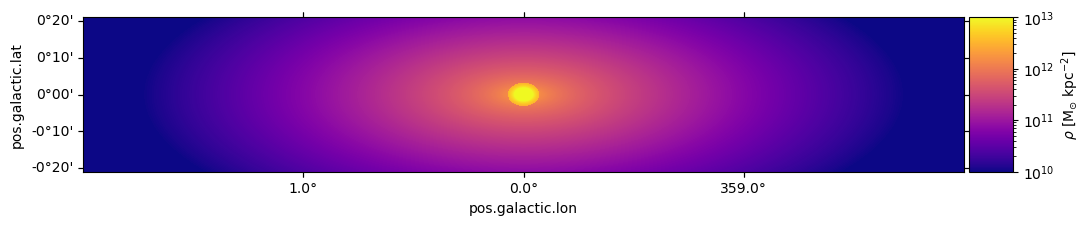

In [108]:
fig, ax = plt.subplots(1,1,figsize=(12,14),facecolor='white', subplot_kw={'projection': wcs})

powmax,powmin = 13,10
norm = cm.LogNorm(vmin=10**powmin, vmax=10**powmax)
im = ax.imshow(hist.T,cmap='plasma', norm=norm, interpolation='nearest',origin='lower')

lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_major_formatter('d.d')

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05,axes_class=maxes.Axes)
plt.colorbar(im, ax=ax,label='$\\rho$ [M$_{\odot}$ kpc$^{-2}$]', cax=cbar, orientation = 'vertical')

